[![movies](80s-movies.jpg)](80s-movies.jpg)

# What should I watch?

**Overview:**<br/>
Using movies & ratings datasets we will create two recommendation engine to predict what movies we should watch. Both engines will use **collaborative filtering** as the preferred method:
1. Item to item
2. Hybrid: User to user, followed by item to item

In a general sense, the engine will group similar users and similar items.

**Method:**<br/>
Typically, the workflow of a collaborative filtering system is:

1. A user expresses his or her preferences by rating items (e.g. books, movies or CDs) of the system. These ratings can be viewed as an approximate representation of the user's interest in the corresponding domain.[![melbourne]
2. The system matches this user's ratings against other users' and finds the people with most "similar" tastes.
3. With similar users, the system recommends items that the similar users have rated highly but not yet being rated by this user (presumably the absence of rating is often considered as the unfamiliarity of an item)

A key problem of collaborative filtering is how to combine and weight the preferences of user neighbors. Sometimes, users can immediately rate the recommended items. As a result, the system gains an increasingly accurate representation of user preferences over time. ~ Wikipedia (https://en.wikipedia.org/wiki/Collaborative_filtering)<br/><br/>
[![movies](met_21_4_493_fig1a.gif)](met_21_4_493_fig1a.gif)
<br/><br/>

In [1]:
import numpy as np 
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
#importing movie metadata and keep necessary columns
meta= pd.read_csv("movies_metadata.csv")
meta= meta[['id', 'original_title', 'original_language']]
meta= meta.rename(columns={'id':'movieId'})
meta = meta[meta['original_language']== 'en']
meta.head()

,movieId,original_title,original_language
0,862,Toy Story,en
1,8844,Jumanji,en
2,15602,Grumpier Old Men,en
3,31357,Waiting to Exhale,en
4,11862,Father of the Bride Part II,en


In [3]:
#importing movie ratings and keep necessary columns
ratings= pd.read_csv("ratings.csv")
ratings= ratings[['userId', 'movieId', 'rating']]

# taking a 2.5MM sample because it can take too long to pivot data later on
ratings=ratings.head(2500000)

#convert data types before merging
meta.movieId =pd.to_numeric(meta.movieId, errors='coerce')
ratings.movieId = pd.to_numeric(ratings.movieId, errors= 'coerce')

#merge the 2 datasets, so that we can have the labels for the movie titles
data= pd.merge(ratings, meta, on='movieId', how='inner')
data.head()

,userId,movieId,rating,original_title,original_language
0,1,858,5.0,Sleepless in Seattle,en
1,3,858,4.0,Sleepless in Seattle,en
2,5,858,5.0,Sleepless in Seattle,en
3,12,858,4.0,Sleepless in Seattle,en
4,20,858,4.5,Sleepless in Seattle,en


In [4]:
#pivot the table so that rows = users and columns = movies and the content is the ratings
matrix= data.pivot_table(index='userId', columns='original_title', values='rating')
matrix.head(10)

original_title,!Women Art Revolution,$5 a Day,'Gator Bait,'R Xmas,'Twas the Night Before Christmas,(A)Sexual,...And the Pursuit of Happiness,10 Items or Less,10 Things I Hate About You,"10,000 BC",...,Æon Flux,Бабник,Грозовые ворота,Дневник его жены,Мой сводный брат Франкенштейн,"Цирк сгорел, и клоуны разбежались",به امید دیدار,مارمولک,რამინი,黑太陽731
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Check to see if the columns are not empty
print('Total ratings score of userId 1: ', matrix.iloc[0].sum())
print('Mean ratings score of userId 1: ', matrix.iloc[0].mean())
print('Ratings Count of userId 1: ', matrix.iloc[0].count())

Total ratings score of userId 1:  30.0
Mean ratings score of userId 1:  4.285714285714286
Ratings Count of userId 1:  7


In [6]:
# Pearson Correlation
def pearsonR(s1, s2):
    s1_c = s1-s1.mean()
    s2_c = s2-s2.mean()
    return np.sum(s1_c * s2_c) / np.sqrt(np.sum(s1_c**2) * np.sum(s2_c**2))

In [7]:
# Create watched list based on userId.
def has_watched(M, userid):
    watched = []
    t = M[M.index==userid].notnull()
    for c in t.columns:
        if t[c].values[0] == True:
            watched.append(c)
    return watched

# Collaborative filtering (item to item)

In [8]:
# The parameters here are: recently watched movie name, matrix name, number of recommendations, and userID.
def recommend(movie, M, n, userid):
    
    # A function called to create watched list based on userID & append recently watched movie
    watched = has_watched(M, userid)
    watched.append(movie)
    
    # A function to make N recommendations based on Pearson Correlation.
    reviews=[]
    for title in M.columns:
        if title in watched:
            continue
        cor = pearsonR(M[movie], M[title])
        if np.isnan(cor):
            continue
        else:
            reviews.append((title, cor))
    
    # Sort the table of movies descending by similarity
    reviews.sort(key= lambda tup: tup[1], reverse=True)
    rev = pd.DataFrame(reviews[:n], columns=['Title', 'Score'])
    return rev

In [9]:
# Enter recently watched movies, number of recommendation and userID
recent_watch = 'RoboCop 3'
num_of_rec = 10
UID = 1

In [10]:
# Call recommendation function
rec = recommend(recent_watch, matrix, num_of_rec, UID)
print('User# {} watch history: {}'.format(UID, has_watched(matrix, UID)))
print('\nBased on the most recent watched movie {}, {} movies you might like:'.format(recent_watch, num_of_rec))
rec

User# 1 watch history: ['Fools Rush In', 'License to Wed', 'Rocky Balboa', 'Shriek If You Know What I Did Last Friday the Thirteenth', 'Shuang ma lian huan', 'Sleepless in Seattle', 'Young and Innocent']

Based on the most recent watched movie RoboCop 3, 10 movies you might like:


,Title,Score
0,RoboCop 2,0.585371
1,Happily N'Ever After,0.542837
2,Fire Birds,0.452897
3,Fred Claus,0.370503
4,Papillon,0.368730
5,The Two Faces of Dr. Jekyll,0.362939
6,Hannah and Her Sisters,0.362792
7,Beyond the Sea,0.343165
8,Hannah Takes the Stairs,0.297294
9,The Phantom of the Opera,0.296282


It gave great recommendations based on what was recently watched, especially sensing that RoboCop 2 is a similar movie to RoboCop 3. 

**Please note:** This model does not look at a similarity between the names of the movie, it looks at the similarties between rating scores of the movies.

Let's try another example of item to item collaborative filtering:

In [11]:
# Enter recently watched movies, number of recommendation and userID
recent_watch = 'To Kill a Mockingbird'
num_of_rec = 10
UID = 3100

In [12]:
# Call recommendation function
rec = recommend(recent_watch, matrix, num_of_rec, UID)
print('User# {} watch history: {}'.format(UID, has_watched(matrix, UID)))
print('\nBased on the most recent watched movie {}, {} movies you might like:'.format(recent_watch, num_of_rec))
rec

User# 3100 watch history: ['5 Card Stud', 'A Nightmare on Elm Street', 'An Unfinished Life', 'And Then There Were None', 'Bad Boys II', 'Batman Returns', 'Berkeley Square', 'Big Fish', "Big Girls Don't Cry... They Get Even", 'Die Hard 2', 'Ghost Dog: The Way of the Samurai', 'Gleaming the Cube', 'Haker', 'Hour of the Gun', 'House of Dracula', 'Leben nach Microsoft', 'Many Rivers to Cross', 'Margaret Thatcher: The Long Walk to Finchley', 'Mega Python vs. Gatoroid', 'New York Doll', 'Pufnstuf', 'Seven Men from Now', 'Silent Hill', 'Sleepless in Seattle', 'Space Chimps 2: Zartog Strikes Back', 'The Dawn Patrol', 'The Garden of Eden', 'The Million Dollar Hotel', 'To Kill a Mockingbird', 'Vice Squad', 'Wag the Dog', "We're No Angels", 'Wedlock', 'xXx']

Based on the most recent watched movie To Kill a Mockingbird, 10 movies you might like:


,Title,Score
0,The Terminal,0.217002
1,Reservoir Dogs,0.183826
2,Psycho,0.172386
3,Night on Earth,0.168636
4,The Searchers,0.163432
5,Reign Over Me,0.162044
6,Titanic,0.156307
7,The Beach,0.156011
8,48 Hrs.,0.151396
9,The Hours,0.149796


The results, once more seems great, from a personal perspective I can say that I enjoyed "To Kill a Mockingbird" as well as the recommended movie list such as "The Terminal", "Reservoir Dogs" & etc...

[![movies](cognitive-bias_feature31.jpg)](cognitive-bias_feature31.jpg)

Item to item collaborative filtering, seems to be doing fairly well, however it doesn't take into account user scoring biased. For example the item to item filtering doesn't account for a harsh scorer or a user that always gives a high score.

The next method (recommendation engine), using **user to user, followed by item to item** collaborative filtering will remove the user bias by grouping similar users first then basing the recommendation by looking at similar items that they have watched. Simply this method is equivalent to saying "Birds of the same feather, flock together".

# Collaborative filtering (user to user, followed by item to item)

In [13]:
# The parameters here are: matrix name, number of similar users, and userID.
def recommend_sim_user(movie, M, n_user, n_rec, userid):
    
    # A function to make N recommendations based on Pearson Correlation.
    users=[]
    for u in range(0, len(M)):
        if u == userid - 1:
            continue
        cor = pearsonR(M.iloc[userid - 1], M.iloc[u])
        if np.isnan(cor):
            continue
        else:
            users.append((u, cor))
    
    # Sort the table of users descending by similarity
    users.sort(key= lambda tup: tup[1], reverse=True)
    usr = pd.DataFrame(users[:n_user], columns=['User', 'Score'])
    
    # Create new matrix with just the similar user to our user
    M2 = M[M.index.isin(usr.User.values)]
    
    # A function called to create watched list based on userID & append recently watched movie
    watched = has_watched(M, userid)
    watched.append(movie)
    
    # A function to make N recommendations based on Pearson Correlation.
    reviews=[]
    for title in M2.columns:
        if title in watched:
            continue
        cor = pearsonR(M2[movie], M2[title])
        if np.isnan(cor):
            continue
        else:
            reviews.append((title, cor))
    
    # Sort the table of movies descending by similarity
    reviews.sort(key= lambda tup: tup[1], reverse=True)
    rev = pd.DataFrame(reviews[:n_rec], columns=['Title', 'Score'])
    
    return usr, rev

**Let's look at the same user:** (userId: 3100, & recently watched movie: To Kill A Mockingbird)

In [14]:
# Enter recently watched movies, number of similar users, number of recommendation and userID
recent_watch = 'To Kill a Mockingbird'
num_of_user = 100
num_of_rec = 10
UID = 3100

In [15]:
# Call recommendation function for user to user followed by item to item
usr, rec = recommend_sim_user(recent_watch, matrix, num_of_user, num_of_rec, UID)

# Print all the results
print('\nBased on what you have rated, below is the top 10 of {} users similar to you:'.format(num_of_user))
print(usr.head(10))
print('\n')
print('\nUser# {} watch history: {}'.format(UID, has_watched(matrix, UID)))
for n in range(0, 6):
    print('\nUser# {} watch history: {}'.format(usr.User[n], has_watched(matrix, usr.User[n])))
print('\n')
print('\nBased on the most recent watched movie {} & {} similar users, {} movies you might like:'.format(recent_watch,
                                                                                                         num_of_user,
                                                                                                         num_of_rec))
print(rec)


Based on what you have rated, below is the top 10 of 100 users similar to you:
    User     Score
0  10522  0.539608
1  10998  0.505299
2   9398  0.481475
3  13691  0.479702
4  22827  0.479702
5   3550  0.465840
6  15550  0.461593
7  12762  0.461227
8  23352  0.448775
9   3282  0.437938



User# 3100 watch history: ['5 Card Stud', 'A Nightmare on Elm Street', 'An Unfinished Life', 'And Then There Were None', 'Bad Boys II', 'Batman Returns', 'Berkeley Square', 'Big Fish', "Big Girls Don't Cry... They Get Even", 'Die Hard 2', 'Ghost Dog: The Way of the Samurai', 'Gleaming the Cube', 'Haker', 'Hour of the Gun', 'House of Dracula', 'Leben nach Microsoft', 'Many Rivers to Cross', 'Margaret Thatcher: The Long Walk to Finchley', 'Mega Python vs. Gatoroid', 'New York Doll', 'Pufnstuf', 'Seven Men from Now', 'Silent Hill', 'Sleepless in Seattle', 'Space Chimps 2: Zartog Strikes Back', 'The Dawn Patrol', 'The Garden of Eden', 'The Million Dollar Hotel', 'To Kill a Mockingbird', 'Vice Squad', 'W

The result is pretty robust as it provides users of similar interest/scoring style, it appears that the movies recommended have more of a a similar complex plot line.

Let's try a different genre: **Action Genre.**

In [16]:
# Enter recently watched movies, number of similar users, number of recommendation and userID
recent_watch = "Ocean's Eleven"
num_of_user = 100
num_of_rec = 10
UID = 20

In [17]:
# Call recommendation function for user to user followed by item to item
usr, rec = recommend_sim_user(recent_watch, matrix, num_of_user, num_of_rec, UID)

# Print all the results
print('\nBased on what you have rated, below is the top 10 of {} users similar to you:'.format(num_of_user))
print(usr.head(10))
print('\n')
print('\nUser# {} watch history: {}'.format(UID, has_watched(matrix, UID)))
for n in range(0, 6):
    print('\nUser# {} watch history: {}'.format(usr.User[n], has_watched(matrix, usr.User[n])))
print('\n')
print('\nBased on the most recent watched movie {} & {} similar users, {} movies you might like:'.format(recent_watch,
                                                                                                         num_of_user,
                                                                                                         num_of_rec))
print(rec)


Based on what you have rated, below is the top 10 of 100 users similar to you:
    User     Score
0  16567  0.309535
1   7784  0.295344
2   4635  0.278431
3   6817  0.275870
4   5512  0.272383
5  12228  0.272283
6   3964  0.262696
7  20062  0.260626
8   7593  0.253012
9   8667  0.247563



User# 20 watch history: ['48 Hrs.', '5 Card Stud', 'A Bridge Too Far', 'Abraham', 'And Then There Were None', 'Barking Water', 'Batman Returns', 'Blood: The Last Vampire', 'Bridge to Terabithia', 'Bring It On', 'Broken Blossoms', 'Cars', 'Color of Night', 'Con Air', 'Conquest of the Planet of the Apes', 'Die Hard 2', 'Edward, My Son', 'Eyes Wide Shut', 'Get Carter', 'Gods and Monsters', 'House of Dracula', 'Indestructible Man', "Jacob's Ladder", 'James Dean', 'Jay and Silent Bob Strike Back', 'Leningrad', 'Letter from an Unknown Woman', 'License to Wed', 'Longitude', 'Memoirs of an Invisible Man', 'MouseHunt', "Ocean's Eleven", 'Pleasantville', 'Reign Over Me', 'Rope', 'Schock', 'Silent Hill', 'Slee

Once more, the result is prety robust as the users are watching similar movies and the recommendation of movies really captures this cluster of users: Action genre.

Let's dig deeper and use a sub-genre: **Action/Sci-Fi Genre.**

In [18]:
# Enter recently watched movies, number of similar users, number of recommendation and userID
recent_watch = 'Batman Returns'
num_of_user = 100
num_of_rec = 10
UID = 504

In [19]:
# Call recommendation function for user to user followed by item to item
usr, rec = recommend_sim_user(recent_watch, matrix, num_of_user, num_of_rec, UID)

# Print the results
print('\nBased on what you have rated, below is the top 10 of {} users similar to you:'.format(num_of_user))
print(usr.head(10))
print('\n')
print('\nUser# {} watch history: {}'.format(UID, has_watched(matrix, UID)))
for n in range(0, 6):
    print('\nUser# {} watch history: {}'.format(usr.User[n], has_watched(matrix, usr.User[n])))
print('\n')
print('\nBased on the most recent watched movie {} & {} similar users, {} movies you might like:'.format(recent_watch,
                                                                                                         num_of_user,
                                                                                                         num_of_rec))
print(rec)


Based on what you have rated, below is the top 10 of 100 users similar to you:
    User     Score
0  23626  0.500944
1   8946  0.461846
2  18668  0.459796
3  18784  0.427457
4  16573  0.404469
5    719  0.403113
6   2743  0.397475
7  21761  0.368440
8   7407  0.362062
9   7589  0.347548



User# 504 watch history: ['48 Hrs.', 'Back to the Future Part II', 'Batman Returns', 'Lost in Translation', "Ocean's Eleven", 'Rain Man', 'Reservoir Dogs', 'Romeo + Juliet', 'Silent Hill', 'Syriana', 'Terminator 3: Rise of the Machines', 'The Conversation', 'The Hours', 'The Million Dollar Hotel']

User# 23626 watch history: ['2001: A Space Odyssey', '48 Hrs.', 'A Clockwork Orange', 'A Nightmare on Elm Street', 'A River Runs Through It', 'Aliens vs Predator: Requiem', 'Armageddon', 'Back to the Future', 'Back to the Future Part II', 'Batman Returns', 'Bend It Like Beckham', 'Big Fish', 'Blackmail', 'Bollywood/Hollywood', 'Bonnie and Clyde', 'D.E.B.S.', 'Dancer in the Dark', "Dave Chappelle's Block P

Again, the result is robust as the users are watching similar movies. The recommendation of movies really captures this cluster of users: **Action/Sci-Fi genre.** It also specifically recommends another Batman movie in addition to movies such as Star Wars, The Lord of the Rings, The Fifth Element, & Terminator 2, please note that it would have recommended Terminator 3, however the user has already watched this. 

[![movies](maxresdefault.jpg)](maxresdefault.jpg)

# Social Networkx of Movies & People

In [20]:
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

In [21]:
# taking a 2K sample
ratings2 = ratings.head(2000)

#convert data types before merging
meta.movieId = pd.to_numeric(meta.movieId, errors='coerce')
ratings2.movieId = pd.to_numeric(ratings2.movieId, errors= 'coerce')

#merge the 2 datasets, so that we can have the labels for the movie titles
data= pd.merge(ratings2, meta, on='movieId', how='inner')
data.head()

,userId,movieId,rating,original_title,original_language
0,1,858,5.0,Sleepless in Seattle,en
1,3,858,4.0,Sleepless in Seattle,en
2,5,858,5.0,Sleepless in Seattle,en
3,12,858,4.0,Sleepless in Seattle,en
4,20,858,4.5,Sleepless in Seattle,en


In [22]:
g = nx.Graph()
user_list = data.userId.unique()
title_list = data.original_title.unique()
print(len(user_list), len(title_list), len(data))

24 389 618


In [23]:
for n in range(0, len(user_list)):
    g.add_node(user_list[n])
for n in range(0, len(title_list)):
    g.add_node(title_list[n])
for n in range(0, len(data)):
    g.add_edge(data.original_title[n], data.userId[n])

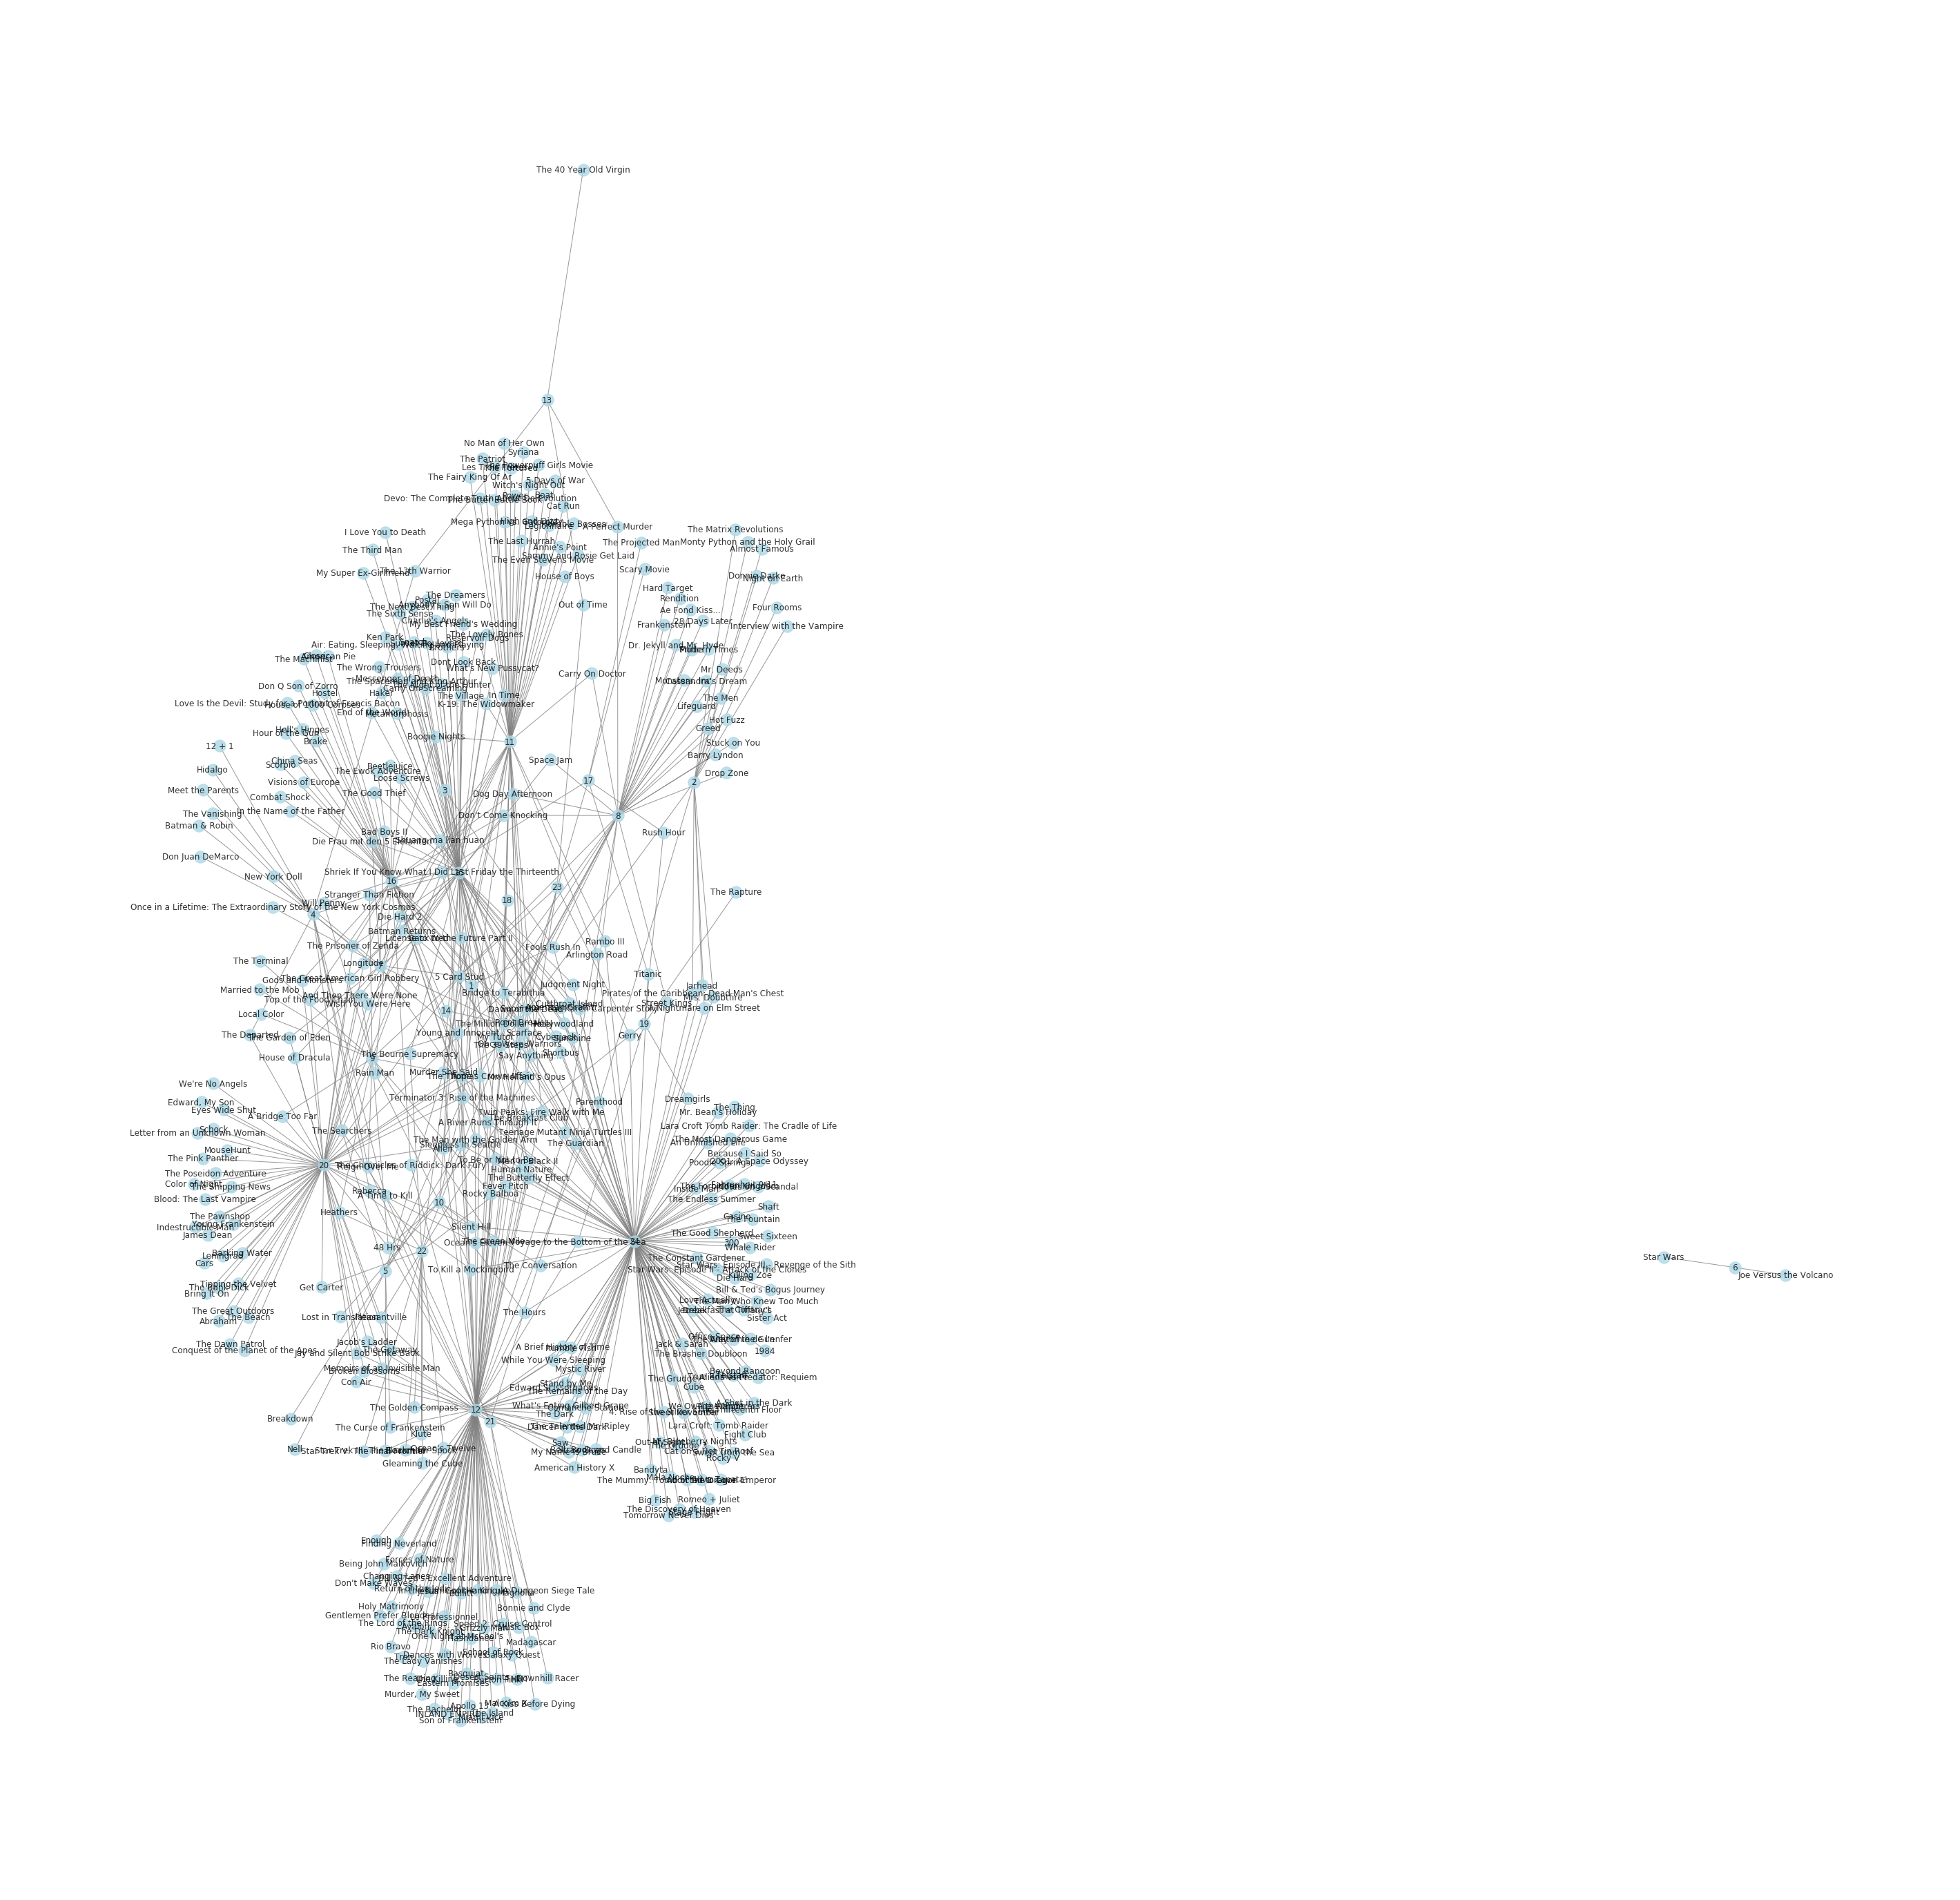

In [24]:
plt.rcParams['figure.figsize']=[50,50]
nx.draw_networkx(g,
                 pos=nx.spring_layout(g, weight='weights'), 
                 node_color='lightblue',
                 edge_color='gray',
                 node_size=300,
                 with_labels=True,
                 alpha=.8,
                 font_size=12,
                 arrows=True)
plt.axis('off')
plt.show()